# DelibAnalysis Clustering

The following script implements the k-means clustering algorithm in order understand the topics of online comments.

In [8]:
# Import libraries

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.cluster import KMeans, MiniBatchKMeans

import sys
from time import time
import pandas as pd
import re
from nltk.corpus import stopwords

import numpy as np

In [9]:
# Clean dataset
dataset = data_df = pd.read_csv('combined_scored.csv')
labels = dataset.columns

vectorizer = TfidfVectorizer(use_idf=True, max_features=1000, analyzer='word', ngram_range=(3,3))

def comment_to_words(raw_comment):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_comment)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return(" ".join(meaningful_words))

clean_train_comments = []

dataset["cleaned_comment"] = dataset["comment"].apply(lambda x: comment_to_words(x))

fit_vectorizer = vectorizer.fit_transform(dataset['cleaned_comment'])
svd = TruncatedSVD(n_components=100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
fit_lsa = lsa.fit_transform(fit_vectorizer)


In [14]:
# Implement KMeans

km = KMeans(n_clusters=5, init='k-means++', max_iter=100, n_init=10,
                verbose=True)
km.fit(fit_lsa)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(fit_lsa, km.labels_, sample_size=1000))


print("Top terms per cluster:") 

original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()
for i in range(5):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print('; %s' % terms[ind], end='')
    print()

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 337.041680109
start iteration
done sorting
end inner loop
Iteration 1, inertia 336.392033525
start iteration
done sorting
end inner loop
Iteration 2, inertia 336.192667328
start iteration
done sorting
end inner loop
Iteration 3, inertia 335.996400892
start iteration
done sorting
end inner loop
Iteration 4, inertia 335.91592989
start iteration
done sorting
end inner loop
Iteration 5, inertia 335.838606546
start iteration
done sorting
end inner loop
Iteration 6, inertia 335.767975996
start iteration
done sorting
end inner loop
Iteration 7, inertia 335.767975996
center shift 0.000000e+00 within tolerance 4.920329e-07
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 341.672953196
start iteration
done sorting
end inner loop
Iteration 1, inertia 338.041112709
start iteration
done sorting
end inner loop
Iteration 2, inertia 337.473090771
start iteration
done sorting

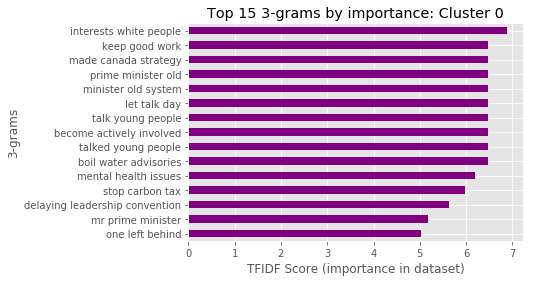

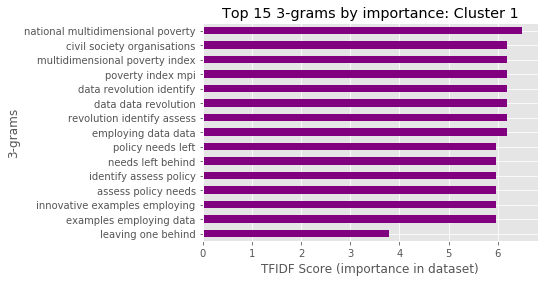

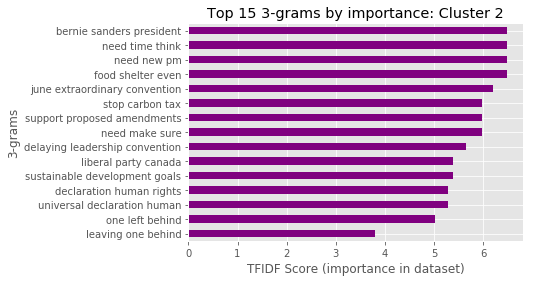

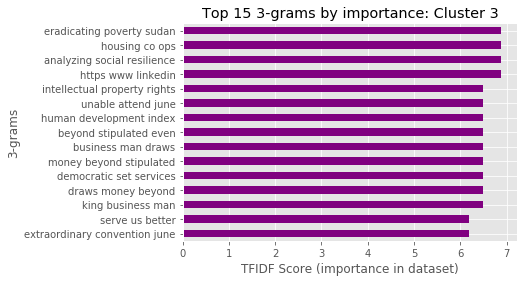

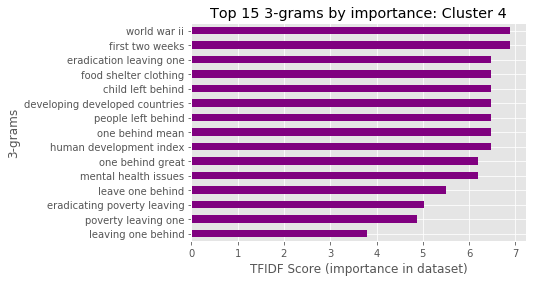

In [15]:
# Visualize top 15 3-grams by importance
idf = vectorizer.idf_
idf_dict = dict(zip(vectorizer.get_feature_names(), idf))
idf_df = pd.DataFrame.from_dict(idf_dict, orient='index')
idf_df = idf_df.sort_values(by=0, ascending=False)
for i in range(5):
    df = pd.DataFrame(columns = ['ngram', 'tf-idf-score'])
    for ind in order_centroids[i, :15]:
        df2 = pd.DataFrame([[terms[ind],idf_df.get_value(index=terms[ind], col=0)]], columns = ['ngram', 'tf-idf-score'])
        df = df.append(df2)
    df = df.sort_values(by='tf-idf-score', ascending=False)
    plt = df.plot(kind='barh', legend=None, color='purple')
    plt.invert_yaxis()
    plt.set_yticklabels(df['ngram'])
    plt.set_title("Top 15 3-grams by importance: Cluster " + str(i))
    plt.set_xlabel("TFIDF Score (importance in dataset)")
    plt.set_ylabel("3-grams")